In [1]:
import os
import itertools
import cv2
import numpy as np 
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet201, EfficientNetB0, NASNetLarge ,Xception, ConvNeXtXLarge
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, VGG19, MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization
warnings.filterwarnings('ignore')
%matplotlib inline

2025-03-03 15:40:24.124444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 15:40:24.124595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 15:40:24.257629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Make DataFrame

In [2]:
data_dir ="/kaggle/input/brain-tumor-mri-images-44c"
paths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds :
    condition_path = os.path.join(data_dir,fold)
    all_pic = os.listdir(condition_path)
    for each_pic in all_pic:
        each_pic_path = os.path.join(condition_path,each_pic)
        paths.append(each_pic_path)
        labels.append(fold.split(' ')[0])
        
pseries = pd.Series(paths, name='Picture Path')
lseries = pd.Series(labels, name='Label')

df = pd.concat([pseries, lseries], axis =1)
df.head()

,Picture Path,Label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma


In [3]:
train_df, ts_df = train_test_split(df,test_size= 0.2,shuffle=True,random_state=42,stratify= df['Label'])
test_df, valid_df = train_test_split(ts_df,test_size= 0.5,shuffle=True,random_state=42,stratify= ts_df['Label'])

## Image Data Generator

In [4]:
batch_size = 32
img_size = (224,224)
gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True, batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True, batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='Picture Path', y_col='Label',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = False, batch_size= batch_size)

Found 3582 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.


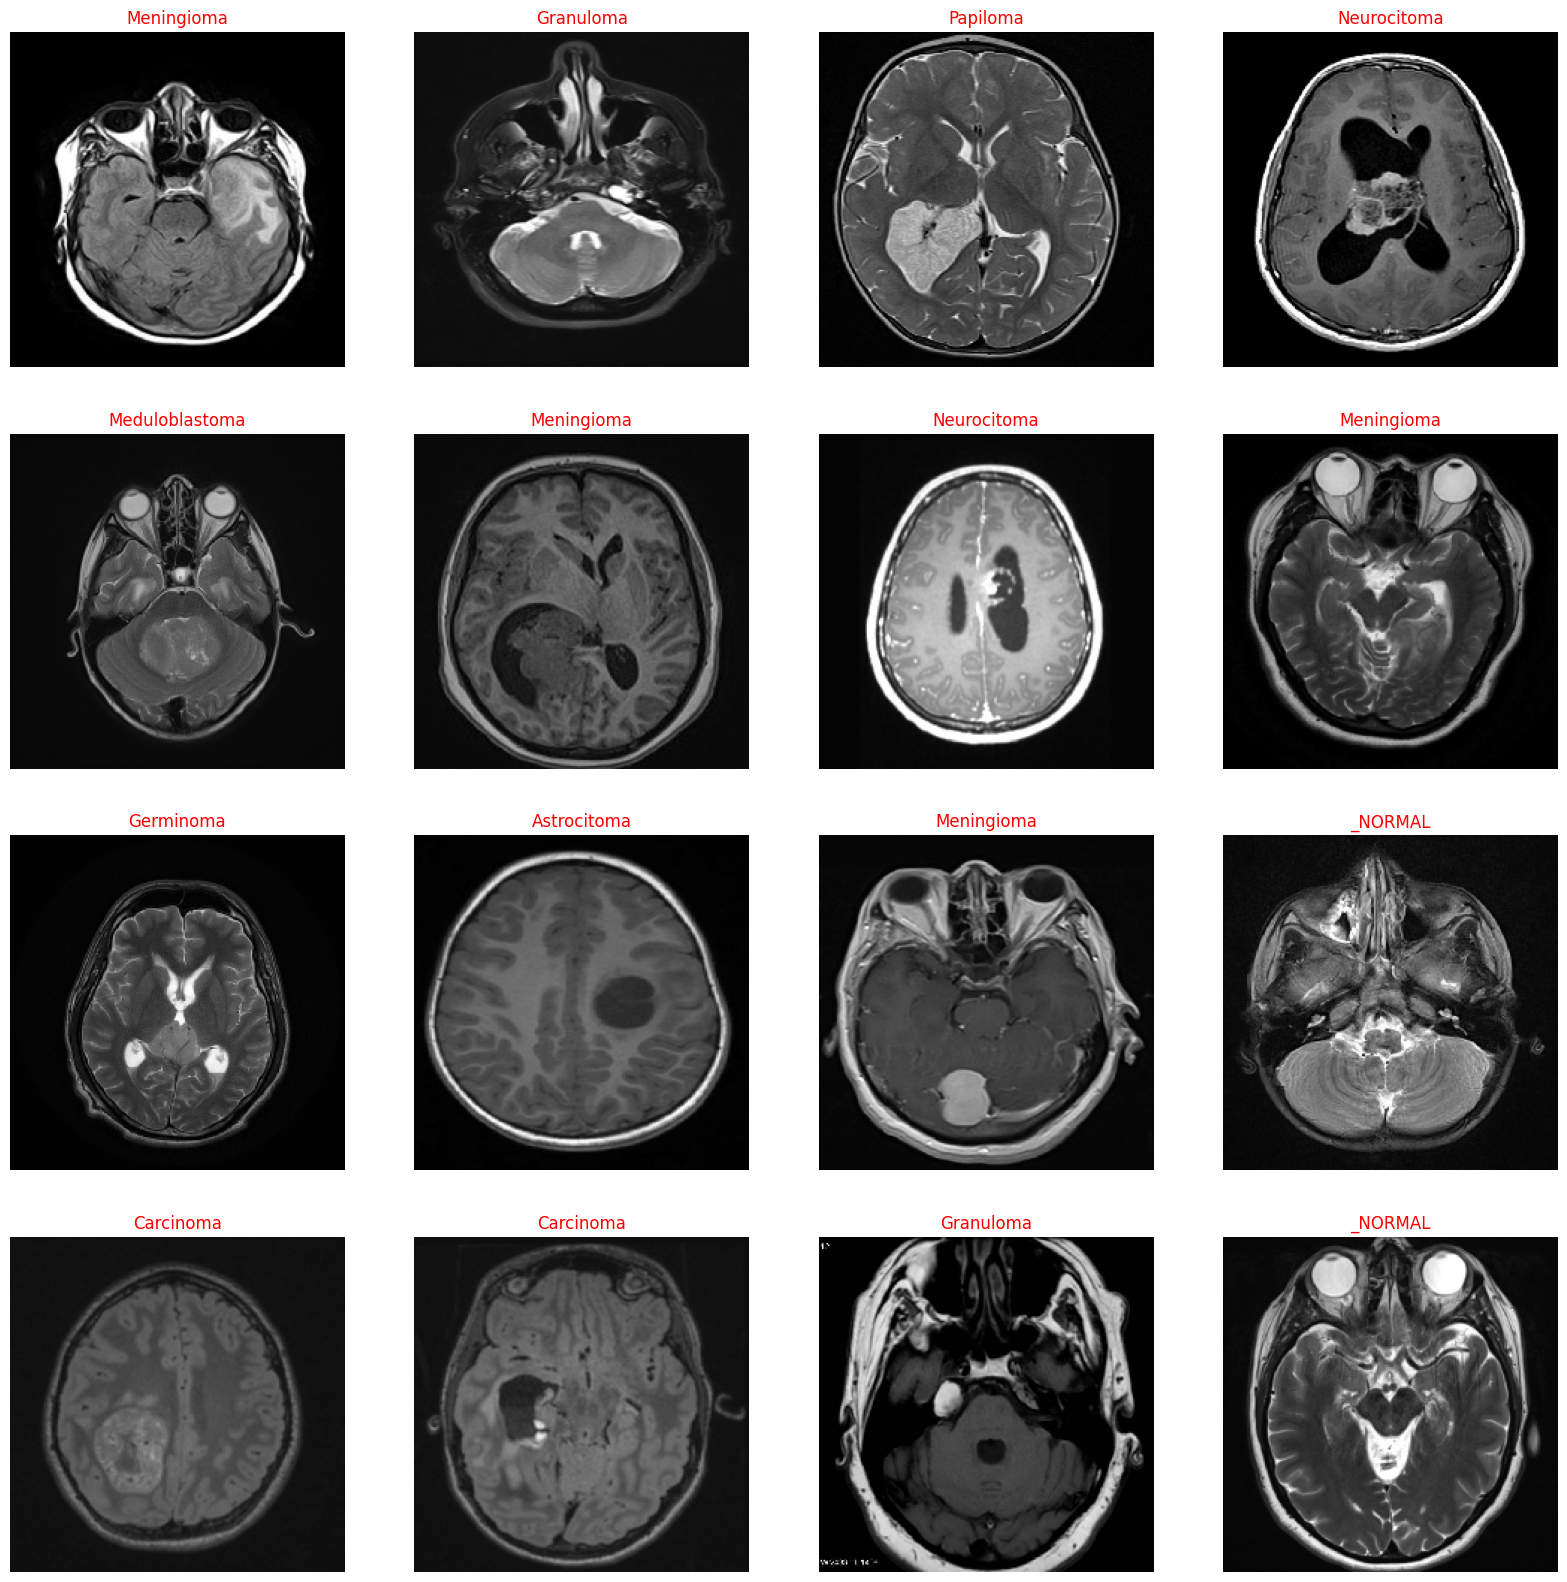

In [5]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())
images, labels = next(train_gen)
plt.figure(figsize= (20,20))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

# Create Model Structure

In [ ]:
img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [7]:
base_model = DenseNet201(include_top= False , weights= "imagenet", input_shape= img_shape, pooling= 'max')
densent = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
densent.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

densent.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32

In [8]:
base_model = Xception(include_top= False , weights= "imagenet", input_shape= img_shape, pooling= 'max')
xcept = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
xcept.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

xcept.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               

In [9]:
base_model = MobileNetV3Large(include_top= False , weights= "imagenet", input_shape= img_shape, pooling= 'max')
mvl = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
mvl.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

mvl.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 960)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 960)               3840      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               246016    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                       

In [10]:
base_model = InceptionV3(include_top= False , weights= "imagenet", input_shape= img_shape, pooling= 'max')
inception = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
inception.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

inception.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_101 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               

In [11]:
base_model = VGG19(include_top= False , weights= "imagenet", input_shape= img_shape, pooling= 'max')
vgg = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),    
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
vgg.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

vgg.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_102 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               

In [12]:
densenet_base = DenseNet201(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
densenet_base.trainable = False  # Freeze DenseNet
efficientnet_base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
efficientnet_base.trainable = False  # Freeze EfficientNet

input_tensor = layers.Input(shape=img_shape)
densenet_output = densenet_base(input_tensor)
efficientnet_output = efficientnet_base(input_tensor)
concatenated = layers.Concatenate()([densenet_output, efficientnet_output])

x = layers.Flatten()(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                 bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = layers.Dropout(rate=0.45, seed=123)(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                 bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = layers.Dropout(rate=0.45, seed=123)(x)
output_tensor = layers.Dense(class_count, activation='softmax')(x)


denseEfficient = models.Model(inputs=input_tensor, outputs=output_tensor)
denseEfficient.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', 
          metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
denseEfficient.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 1920)                 1832198   ['input_8[0][0]']             
                                                          4                                       
                                                                                                  
 efficientnetb0 (Functional  (None, 1280)                 4049571   ['input_8[0][0]']             
 )                                                                                                
                             

In [13]:
hist= denseEfficient.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/20


2025-03-03 15:41:22.780087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1741016488.537346      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 [==============================] - 72s 460ms/step - loss: 11.2194 - accuracy: 0.3311 - precision_5: 0.5583 - recall_5: 0.1189 - auc_5: 0.7886 - val_loss: 9.3721 - val_accuracy: 0.6071 - val_precision_5: 0.9333 - val_recall_5: 0.2188 - val_auc_5: 0.9287
Epoch 2/20
112/112 [==============================] - 17s 148ms/step - loss: 8.6821 - accuracy: 0.5489 - precision_5: 0.8409 - recall_5: 0.2641 - auc_5: 0.9083 - val_loss: 7.6820 - val_accuracy: 0.6920 - val_precision_5: 0.9383 - val_recall_5: 0.3393 - val_auc_5: 0.9606
Epoch 3/20
112/112 [==============================] - 17s 147ms/step - loss: 7.2922 - accuracy: 0.6326 - precision_5: 0.8863 - recall_5: 0.3417 - auc_5: 0.9407 - val_loss: 6.4486 - val_accuracy: 0.7522 - val_precision_5: 0.9679 - val_recall_5: 0.4710 - val_auc_5: 0.9760
Epoch 4/20
112/112 [==============================] - 17s 148ms/step - loss: 6.1598 - accuracy: 0.7038 - precision_5: 0.9232 - recall_5: 0.4428 - auc_5: 0.9602 - val_loss: 5.4654 - val_accuracy: 0.

In [14]:
hist_densenet= densent.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/20
112/112 [==============================] - 142s 454ms/step - loss: 9.4177 - accuracy: 0.3841 - precision: 0.7410 - recall: 0.1494 - auc: 0.8083 - val_loss: 9.6682 - val_accuracy: 0.3549 - val_precision: 0.3918 - val_recall: 0.3192 - val_auc: 0.8144
Epoch 2/20
112/112 [==============================] - 35s 313ms/step - loss: 6.5715 - accuracy: 0.6750 - precision: 0.9088 - recall: 0.4425 - auc: 0.9468 - val_loss: 6.1550 - val_accuracy: 0.6786 - val_precision: 0.7864 - val_recall: 0.5670 - val_auc: 0.9510
Epoch 3/20
112/112 [==============================] - 35s 313ms/step - loss: 5.2202 - accuracy: 0.8090 - precision: 0.9543 - recall: 0.6301 - auc: 0.9800 - val_loss: 4.7726 - val_accuracy: 0.7857 - val_precision: 0.9500 - val_recall: 0.6362 - val_auc: 0.9853
Epoch 4/20
112/112 [==============================] - 35s 314ms/step - loss: 4.2281 - accuracy: 0.8811 - precision: 0.9779 - recall: 0.7401 - auc: 0.9924 - val_loss: 3.9007 - val_accuracy: 0.8527 - val_precision: 0.9405 - 

In [15]:
hist_inception= inception.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/20
112/112 [==============================] - 56s 222ms/step - loss: 12.4796 - accuracy: 0.2973 - precision_3: 0.4582 - recall_3: 0.0826 - auc_3: 0.7490 - val_loss: 12.4769 - val_accuracy: 0.2746 - val_precision_3: 0.5031 - val_recall_3: 0.1830 - val_auc_3: 0.7625
Epoch 2/20
112/112 [==============================] - 18s 160ms/step - loss: 10.1264 - accuracy: 0.5567 - precision_3: 0.8531 - recall_3: 0.2870 - auc_3: 0.8877 - val_loss: 9.4400 - val_accuracy: 0.6339 - val_precision_3: 0.9032 - val_recall_3: 0.3750 - val_auc_3: 0.9304
Epoch 3/20
112/112 [==============================] - 18s 161ms/step - loss: 8.6558 - accuracy: 0.6884 - precision_3: 0.9099 - recall_3: 0.4626 - auc_3: 0.9415 - val_loss: 7.9236 - val_accuracy: 0.7433 - val_precision_3: 0.9697 - val_recall_3: 0.5000 - val_auc_3: 0.9759
Epoch 4/20
112/112 [==============================] - 18s 162ms/step - loss: 7.4329 - accuracy: 0.7820 - precision_3: 0.9536 - recall_3: 0.5972 - auc_3: 0.9718 - val_loss: 6.7757 - val

In [16]:
hist_mvl= mvl.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/20
112/112 [==============================] - 41s 152ms/step - loss: 11.4976 - accuracy: 0.3236 - precision_2: 0.5701 - recall_2: 0.1351 - auc_2: 0.7853 - val_loss: 10.8748 - val_accuracy: 0.3371 - val_precision_2: 0.5769 - val_recall_2: 0.0335 - val_auc_2: 0.7645
Epoch 2/20
112/112 [==============================] - 14s 124ms/step - loss: 9.1592 - accuracy: 0.5910 - precision_2: 0.8795 - recall_2: 0.3445 - auc_2: 0.9229 - val_loss: 9.3582 - val_accuracy: 0.2991 - val_precision_2: 0.4945 - val_recall_2: 0.1004 - val_auc_2: 0.7819
Epoch 3/20
112/112 [==============================] - 14s 121ms/step - loss: 7.5321 - accuracy: 0.7278 - precision_2: 0.9510 - recall_2: 0.5098 - auc_2: 0.9647 - val_loss: 8.1936 - val_accuracy: 0.2634 - val_precision_2: 0.3885 - val_recall_2: 0.1362 - val_auc_2: 0.7909
Epoch 4/20
112/112 [==============================] - 14s 121ms/step - loss: 6.1899 - accuracy: 0.8236 - precision_2: 0.9694 - recall_2: 0.6360 - auc_2: 0.9844 - val_loss: 6.9026 - val_

In [17]:
hist_xception= xcept.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/20
112/112 [==============================] - 62s 334ms/step - loss: 12.0085 - accuracy: 0.3730 - precision_1: 0.6841 - recall_1: 0.1281 - auc_1: 0.7830 - val_loss: 11.1187 - val_accuracy: 0.2991 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.7191
Epoch 2/20
112/112 [==============================] - 31s 273ms/step - loss: 9.3752 - accuracy: 0.6678 - precision_1: 0.9451 - recall_1: 0.4277 - auc_1: 0.9421 - val_loss: 9.5836 - val_accuracy: 0.2991 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.7958
Epoch 3/20
112/112 [==============================] - 31s 274ms/step - loss: 7.6570 - accuracy: 0.7956 - precision_1: 0.9762 - recall_1: 0.6192 - auc_1: 0.9787 - val_loss: 7.8335 - val_accuracy: 0.7790 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.9521
Epoch 4/20
112/112 [==============================] - 31s 273ms/step - loss: 6.2390 - accuracy: 0.8802 - precision_1: 0.9868 - recall_1: 0.7323 - auc_1: 0.9930 -

In [18]:
hist_vgg= vgg.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/20
112/112 [==============================] - 53s 345ms/step - loss: 9.6908 - accuracy: 0.2197 - precision_4: 0.2292 - recall_4: 0.0031 - auc_4: 0.6926 - val_loss: 12.6530 - val_accuracy: 0.2299 - val_precision_4: 0.3080 - val_recall_4: 0.1808 - val_auc_4: 0.7107
Epoch 2/20
112/112 [==============================] - 29s 261ms/step - loss: 7.5555 - accuracy: 0.2884 - precision_4: 0.4091 - recall_4: 0.0050 - auc_4: 0.7688 - val_loss: 7.0452 - val_accuracy: 0.3036 - val_precision_4: 0.3922 - val_recall_4: 0.0446 - val_auc_4: 0.7711
Epoch 3/20
112/112 [==============================] - 29s 261ms/step - loss: 6.2502 - accuracy: 0.3322 - precision_4: 0.4818 - recall_4: 0.0148 - auc_4: 0.7915 - val_loss: 5.7917 - val_accuracy: 0.3371 - val_precision_4: 0.5714 - val_recall_4: 0.0089 - val_auc_4: 0.8032
Epoch 4/20
112/112 [==============================] - 29s 260ms/step - loss: 5.2529 - accuracy: 0.3760 - precision_4: 0.6562 - recall_4: 0.0469 - auc_4: 0.8183 - val_loss: 5.0174 - val_a

In [19]:
def plots(x):
    tr_acc = x.history['accuracy']
    tr_loss = x.history['loss']
    val_acc = x.history['val_accuracy']
    val_loss = x.history['val_loss']

    index_acc = np.argmax(val_acc) 
    index_loss = np.argmin(val_loss)

    val_lowest=val_loss[index_loss]
    acc_highest=val_acc[index_acc]

    epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch = {str(index_loss+1)}'
    acc_label =  f'best epoch = {str(index_acc+1)} '

    plt.figure(figsize= (20,8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1,2,1)
    plt.plot(epochs,val_loss,c='g',label= 'Testing Loss')
    plt.plot(epochs,tr_loss,c='r',label= 'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs, tr_acc, c='r', label= 'Training Accuracy')
    plt.plot(epochs, val_acc, c='g', label= 'Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.show()

Hybrid DenseEfficient


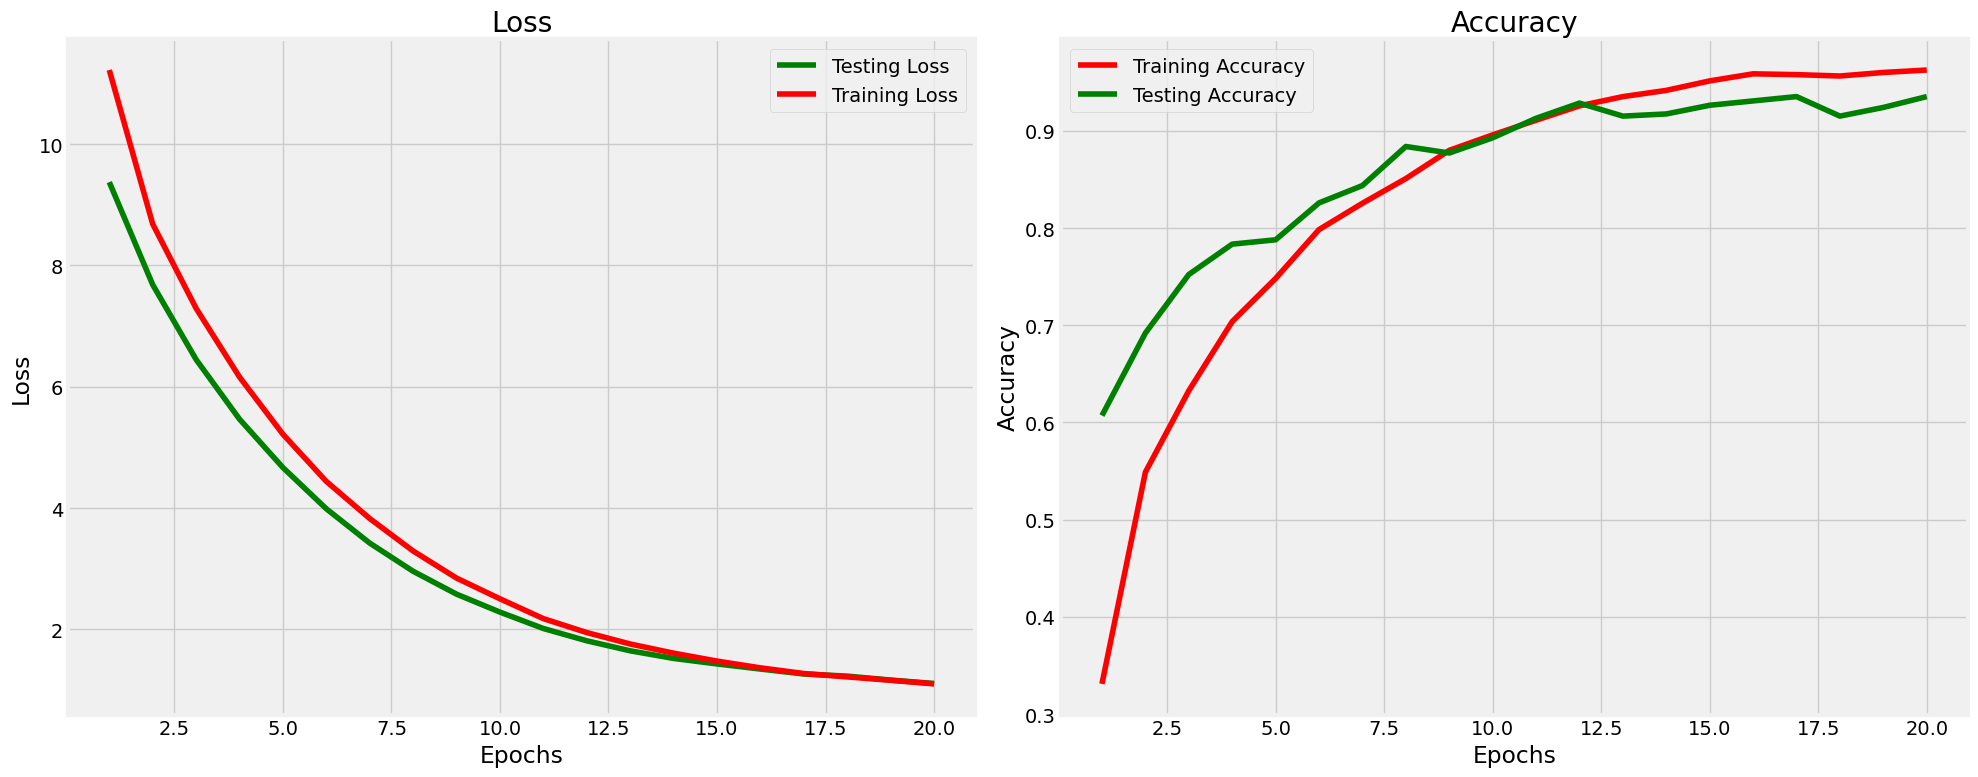

VGG19


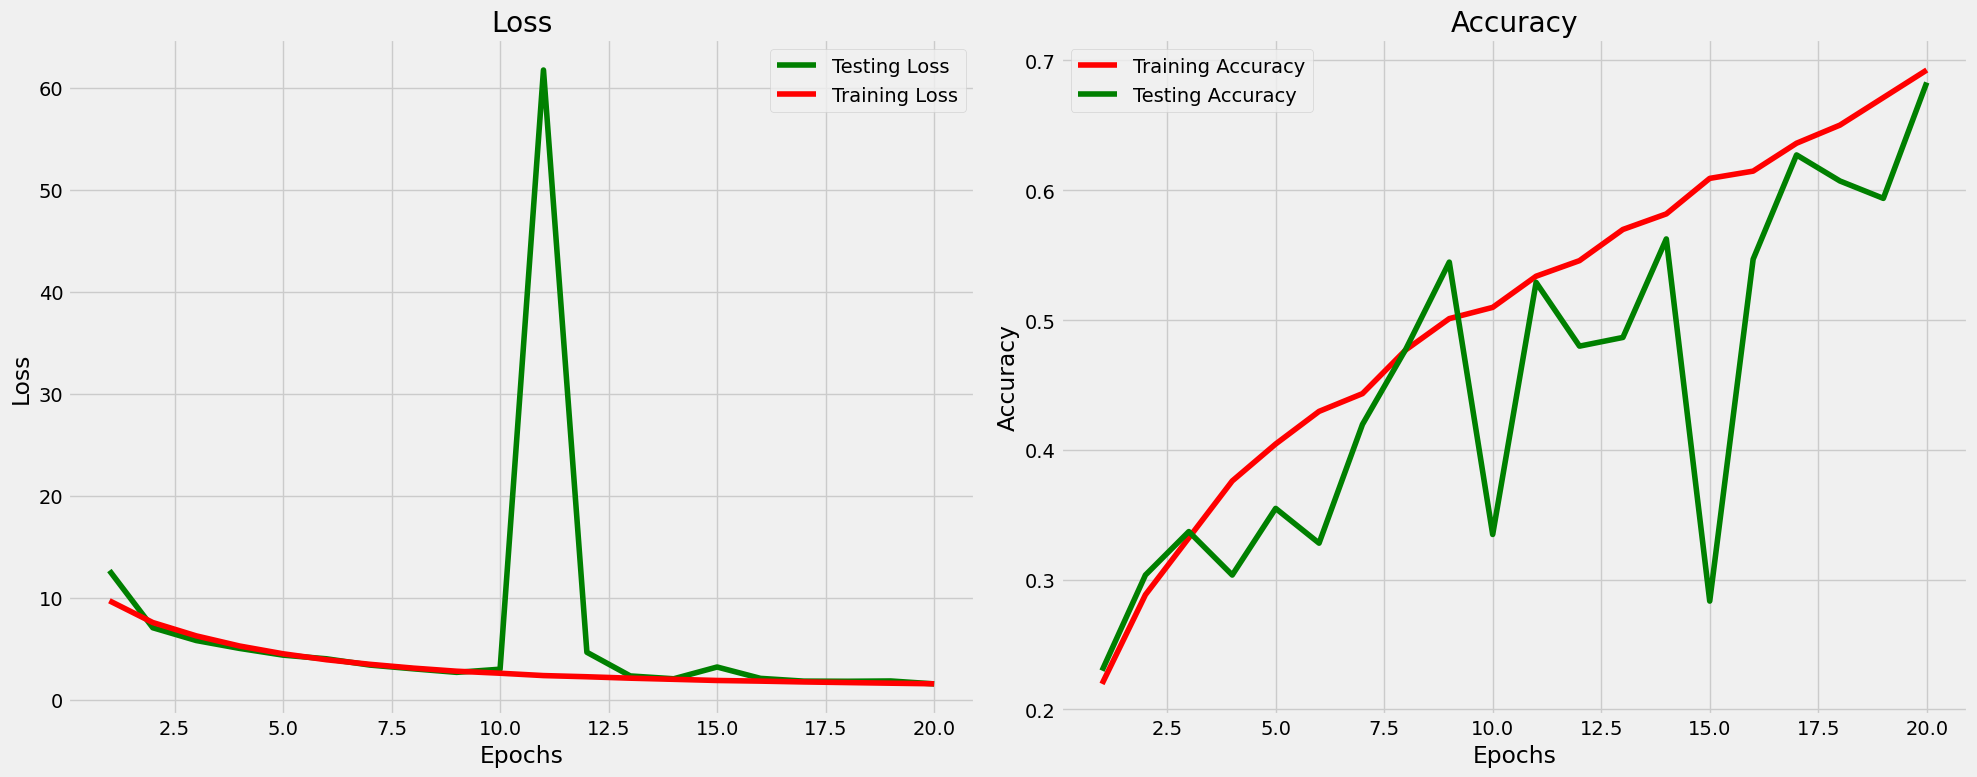

Xception


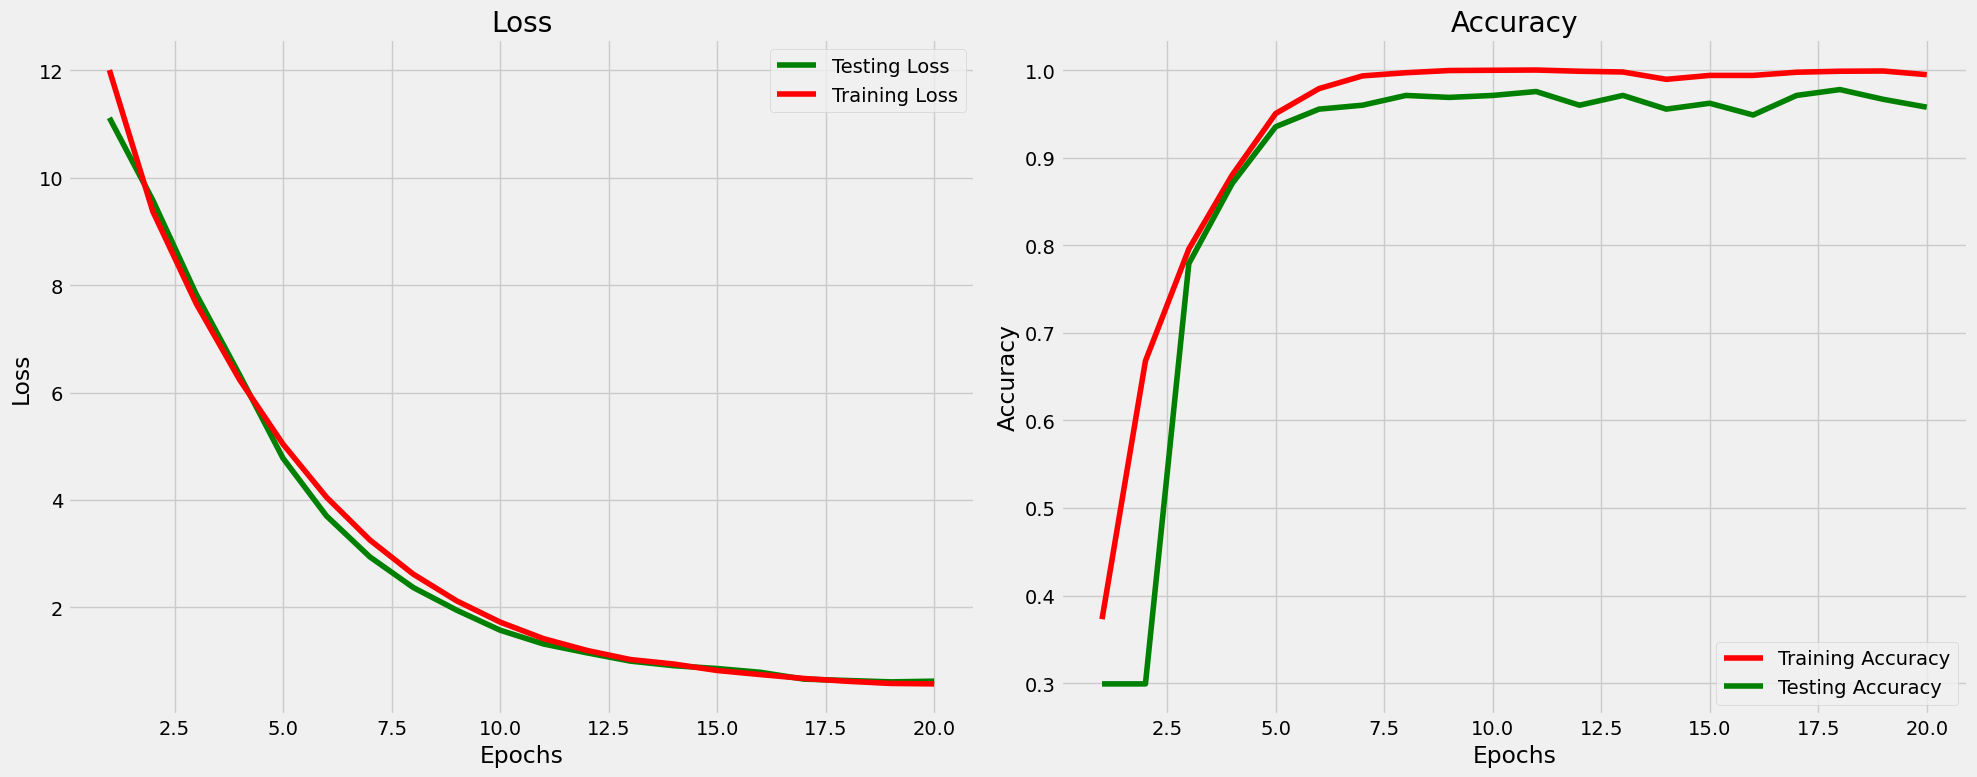

Mobilenet


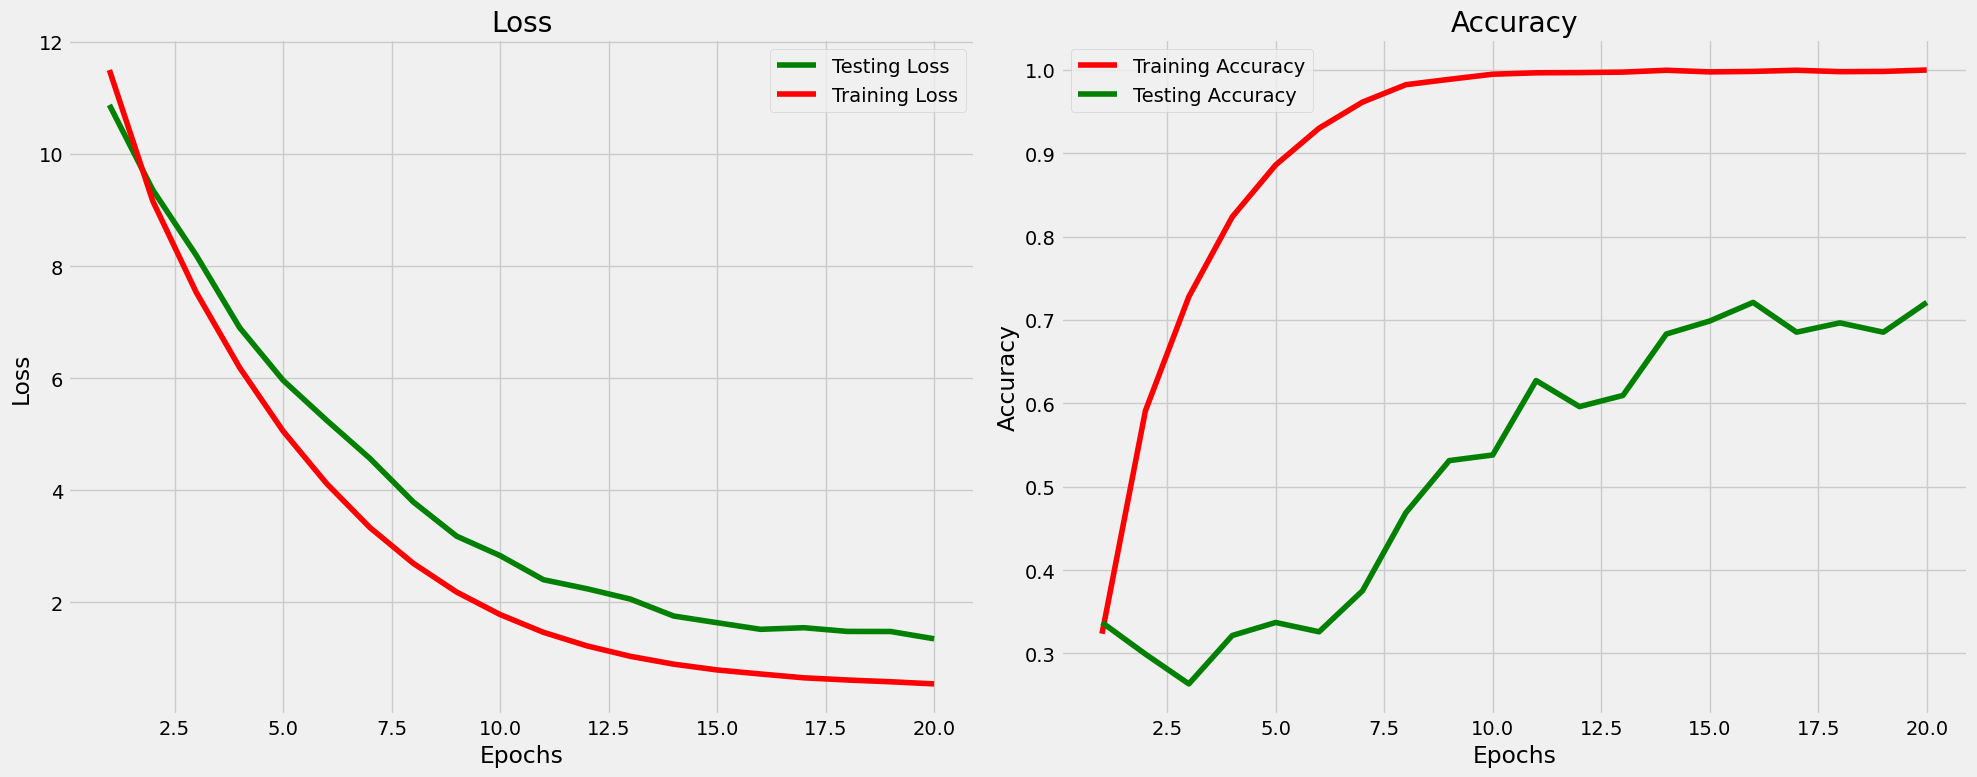

Densenet


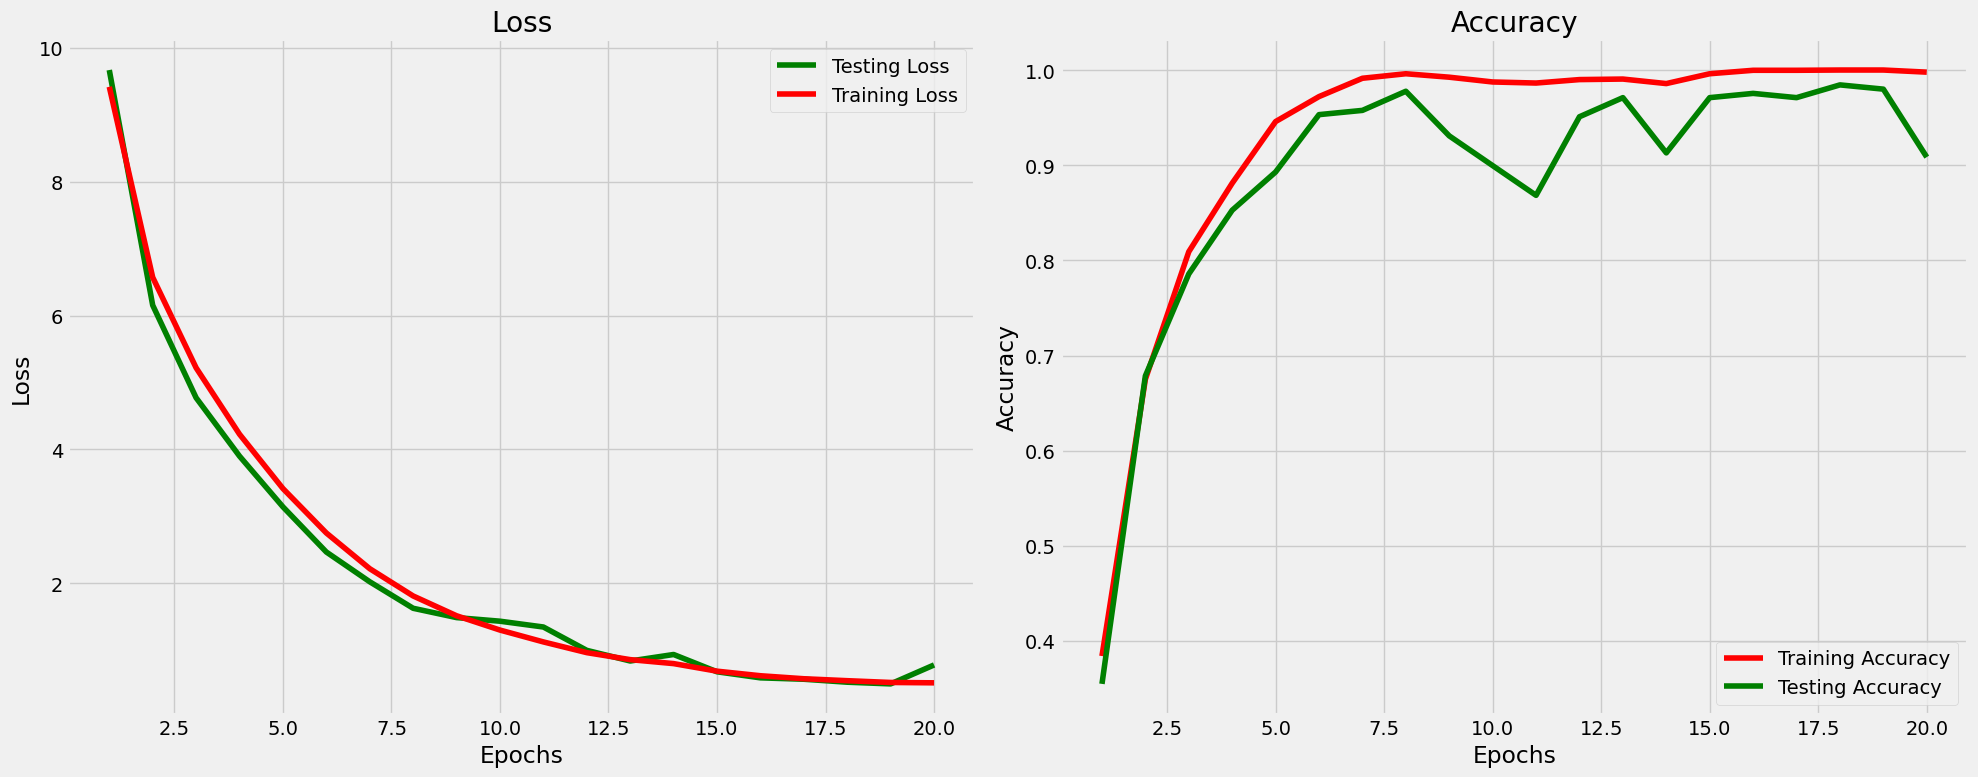

Inception


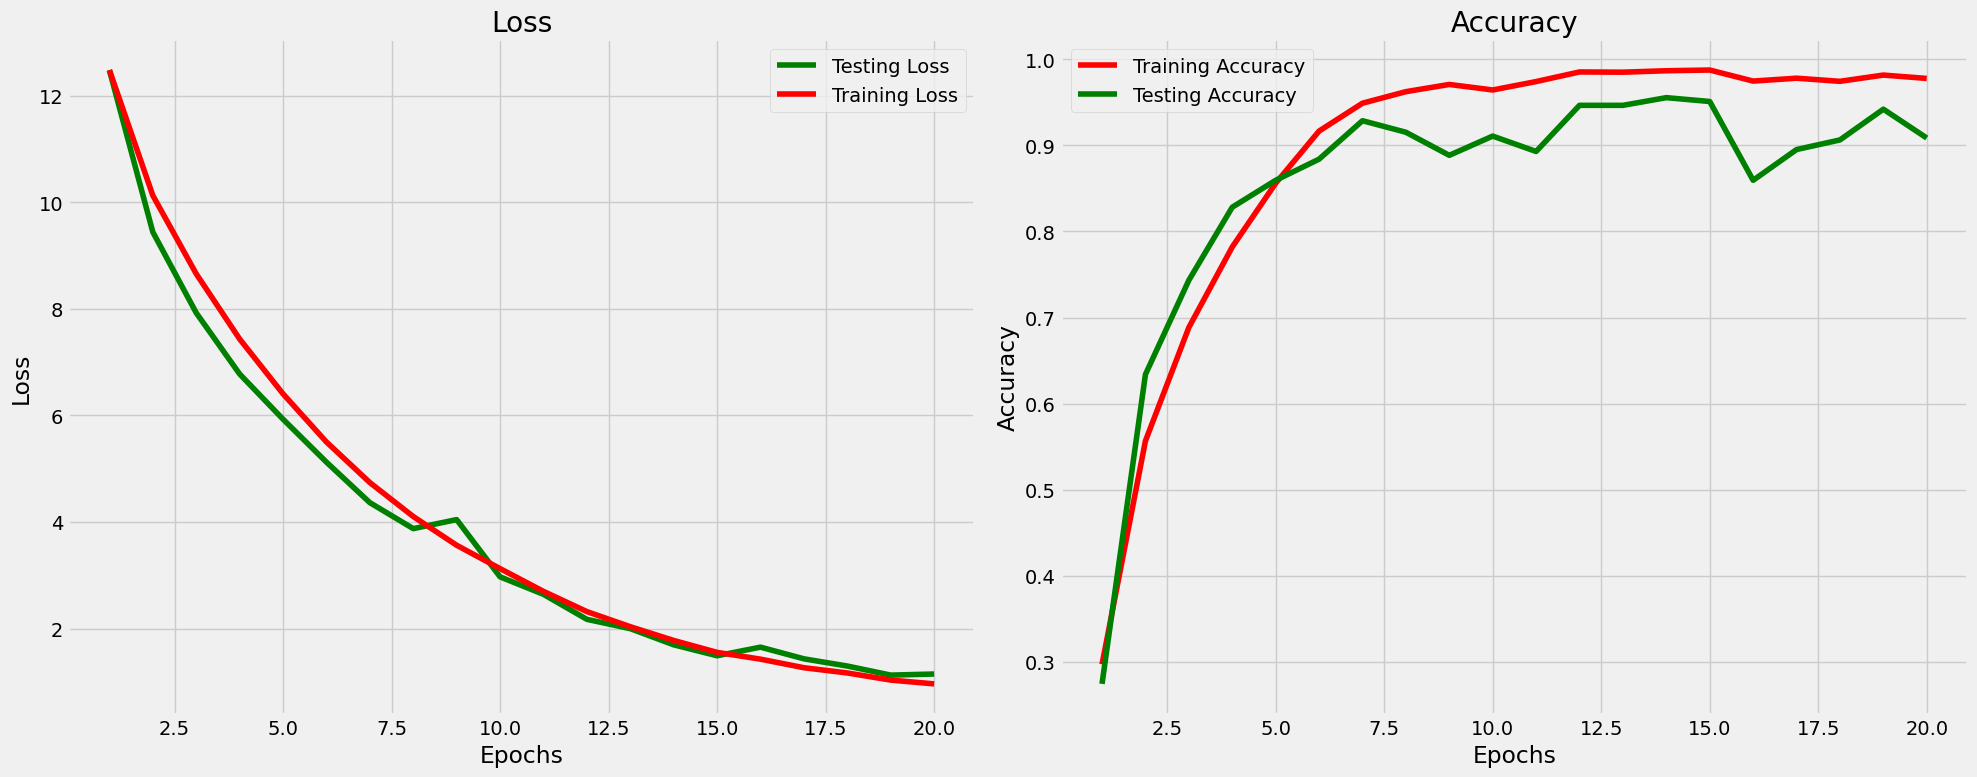

In [20]:
print("Hybrid DenseEfficient")
plots(hist)
print("VGG19")
plots(hist_vgg)
print("Xception")
plots(hist_xception)
print("Mobilenet")
plots(hist_mvl)
print("Densenet")
plots(hist_densenet)
print("Inception")
plots(hist_inception)

In [21]:
def showinfo(x):
    train_score = x.evaluate(train_gen)
    valid_score = x.evaluate(valid_gen)
    test_score =  x.evaluate(test_gen)
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 30)
    print("Valid Loss: ", valid_score[0])
    print("Valid Accuracy: ", valid_score[1])
    print('-' * 30)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

In [22]:
print("Hybrid DenseEfficient")
showinfo(denseEfficient)
print('-'*100)
print("Moblinet")
showinfo(mvl)
print('-'*100)
print("Inception")
showinfo(inception)
print('-'*100)
print("Xception")
showinfo(xcept)
print('-'*100)
print("Dense")
showinfo(densent)
print('-'*100)
print("VGG19")
showinfo(vgg)

Hybrid DenseEfficient
14/14 [==============================] - 5s 370ms/step - loss: 1.1457 - accuracy: 0.9174 - precision_5: 0.9575 - recall_5: 0.8549 - auc_5: 0.9963
Train Loss:  0.9118260145187378
Train Accuracy:  0.9963707327842712
------------------------------
Valid Loss:  1.1086952686309814
Valid Accuracy:  0.9352678656578064
------------------------------
Test Loss:  1.1457195281982422
Test Accuracy:  0.9174107313156128
----------------------------------------------------------------------------------------------------
Moblinet
14/14 [==============================] - 2s 109ms/step - loss: 1.3918 - accuracy: 0.7121 - precision_2: 0.8562 - recall_2: 0.5848 - auc_2: 0.9536
Train Loss:  1.1719274520874023
Train Accuracy:  0.7973199486732483
------------------------------
Valid Loss:  1.3520957231521606
Valid Accuracy:  0.7209821343421936
------------------------------
Test Loss:  1.3917664289474487
Test Accuracy:  0.7120535969734192
------------------------------------------------

In [23]:
def confuse(x):
    preds = x.predict_generator(test_gen)
    y_pred= np.argmax(preds,axis=1)
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Reds)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Hybrid DenseEfficient


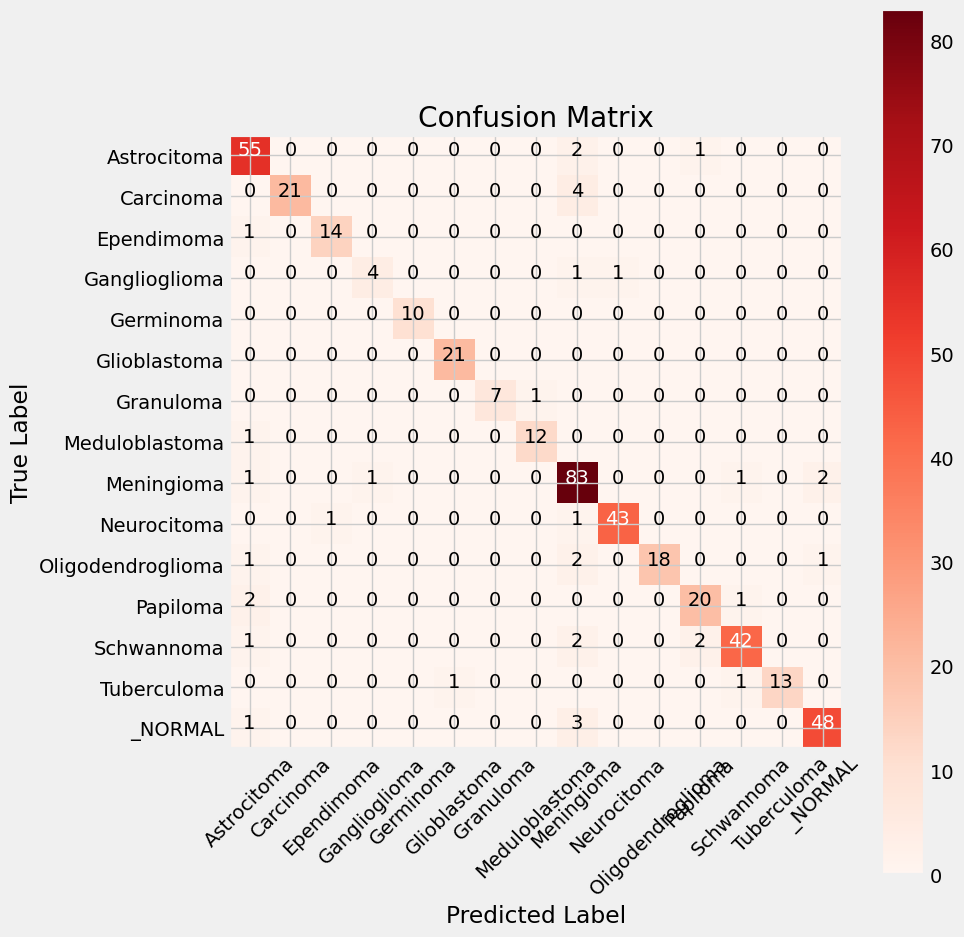

----------------------------------------------------------------------------------------------------
Moblinet


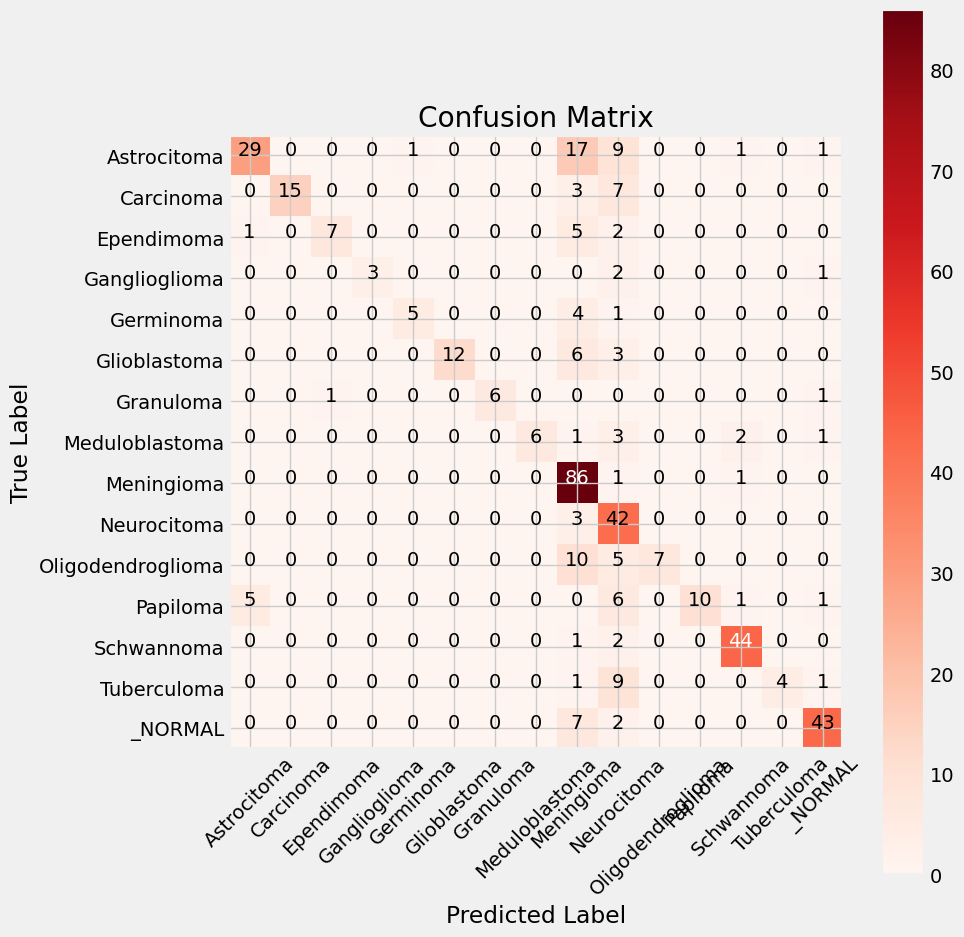

----------------------------------------------------------------------------------------------------
Inception


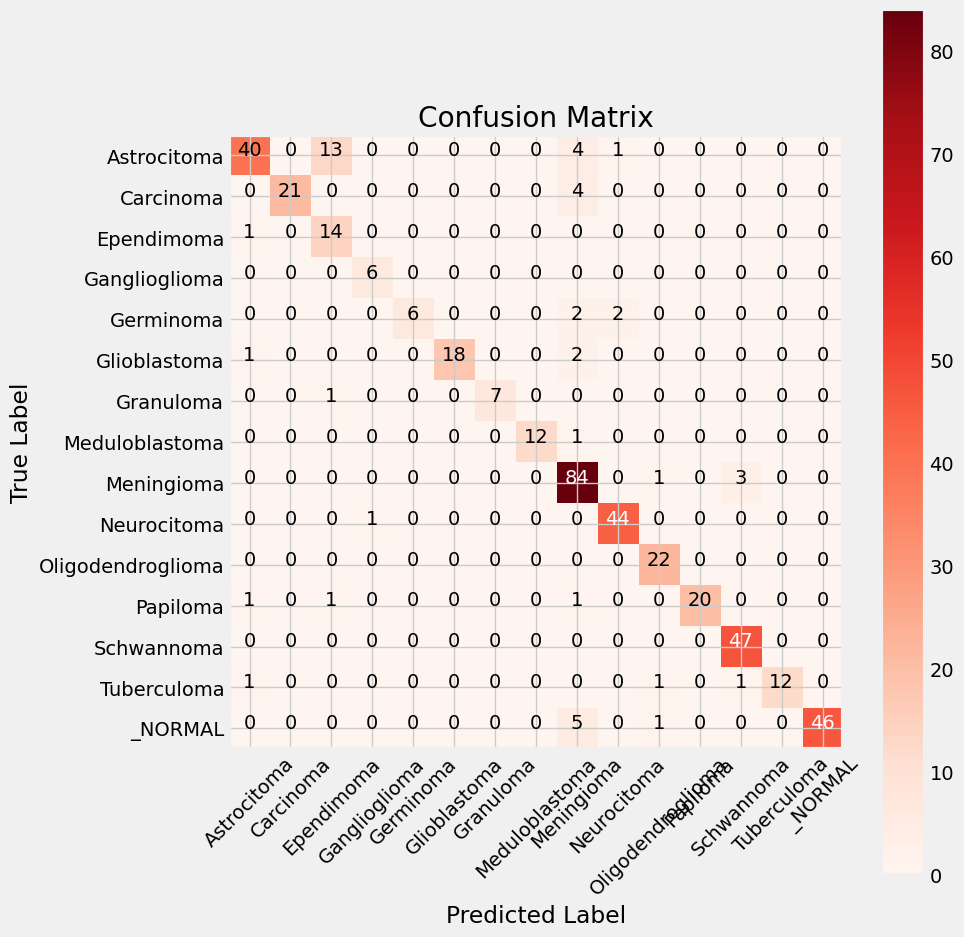

----------------------------------------------------------------------------------------------------
Xception


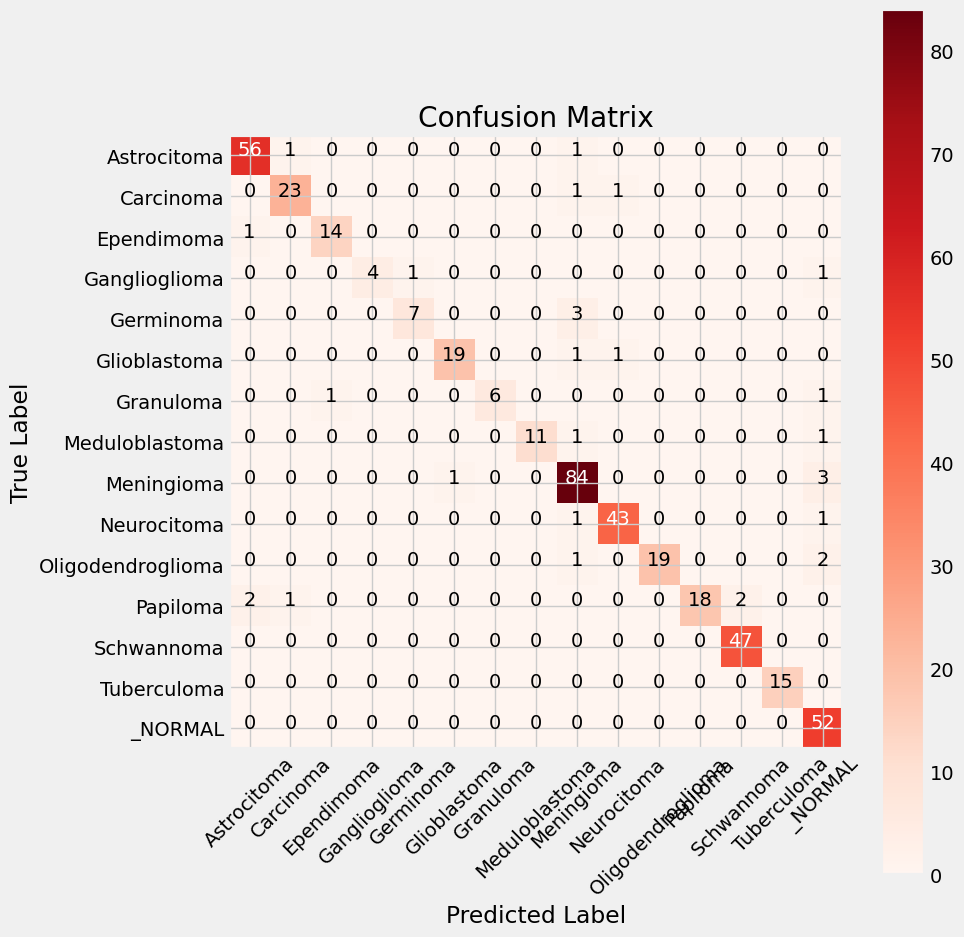

----------------------------------------------------------------------------------------------------


In [ ]:
print("Hybrid DenseEfficient")
confuse(denseEfficient)
print('-'*100)
print("Moblinet")
confuse(mvl)
print('-'*100)
print("Inception")
    confuse(inception)
print('-'*100)
print("Xception")
confuse(xcept)
print('-'*100)


Dense


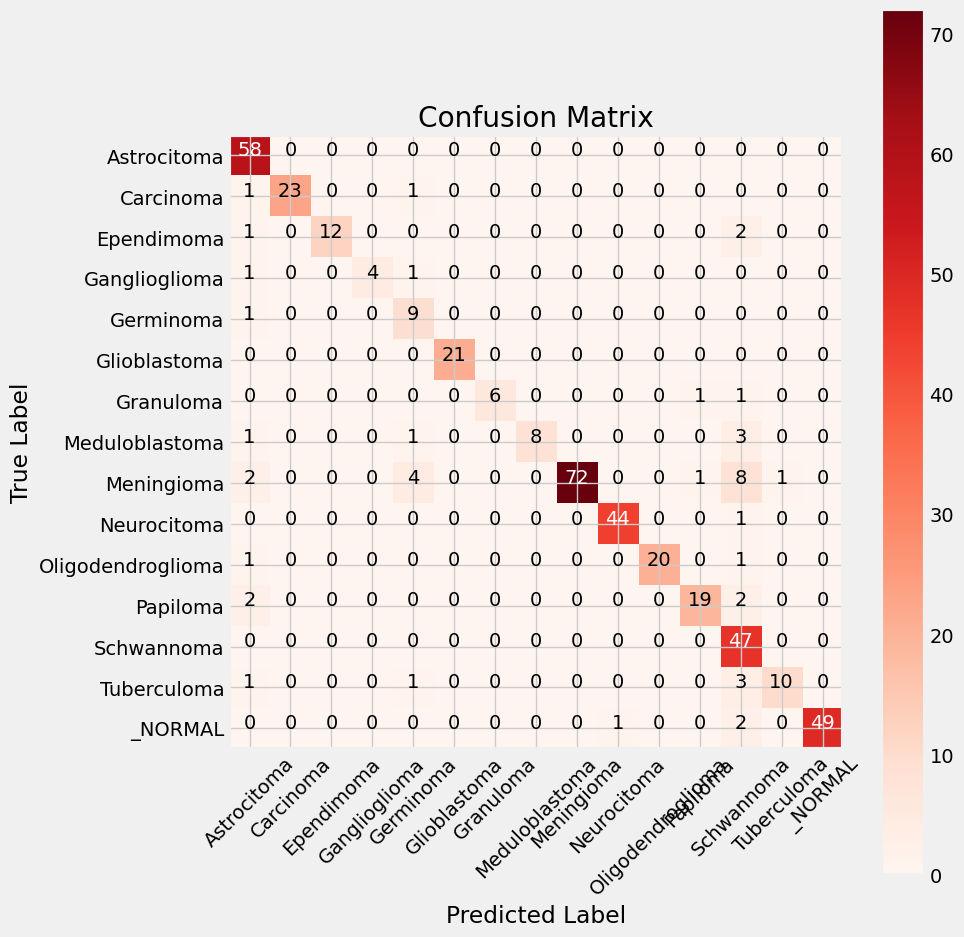

----------------------------------------------------------------------------------------------------
Vgg19


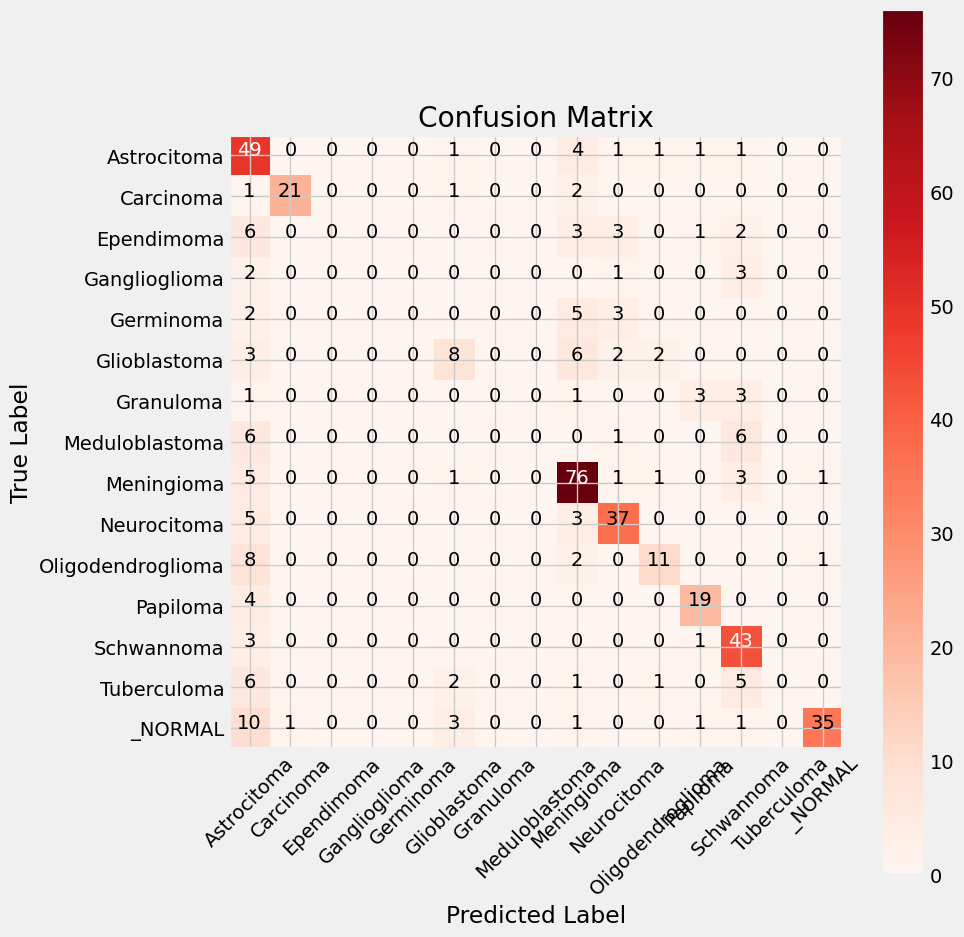

In [25]:
print("Dense")
confuse(densent)
print('-'*100)
print("Vgg19")
confuse(vgg)